In [129]:
# Initialize spark sessions
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

# Common plotting libraries
%matplotlib notebook
import matplotlib.pyplot as plt # side-stepping mpl backend
import matplotlib.gridspec as gridspec # subplots
import pandas

spark = SparkSession \
    .builder \
    .appName("TweetAnalysis") \
    .getOrCreate()

In [130]:
# Read in tweets, users and entities and store them into Spark SQL tables
for table in ['tweets','users','entities']:
    df = spark.read.json('data/processed/'+table+'/*')
    df.createOrReplaceTempView(table)
    print(table + ' schema:')
    df.printSchema()

tweets schema:
root
 |-- created_at: long (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- id: long (nullable = true)
 |-- in_reply_to_status_id: long (nullable = true)
 |-- lang: string (nullable = true)
 |-- quoted_status_id: long (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- retweeted_status_id: long (nullable = true)
 |-- source: string (nullable = true)
 |-- text: string (nullable = true)
 |-- type: string (nullable = true)
 |-- user_id: long (nullable = true)

users schema:
root
 |-- description: string (nullable = true)
 |-- favourites_count: long (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- friends_count: long (nullable = true)
 |-- id: long (nullable = true)
 |-- lang: string (nullable = true)
 |-- listed_count: long (nullable = true)
 |-- name: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- statuses_count: long (nullable = true)
 |-- utc_offset: long (nullable = true)

entities schema:
root

In [131]:
# Pull data into dataframes for processing
tweets = spark.sql("select * from tweets").distinct()
print('%d Total Tweets' % tweets.count())
users = spark.sql("select * from users").distinct()
entities = spark.sql("select * from entities").distinct().withColumn('value', lower(col('value')))

390943 Total Tweets


In [132]:
# Basic Tweet Analysis & Statistics
## Get all tweets that mention @amazon
amazonTweets = tweets.join(entities, 'id')\
    .filter(entities.type == 'mention')\
    .join(users.filter(users.screen_name == 'amazon').select('id').distinct(), 
          users.id == entities.value)\
    .select(tweets.id)\
    .distinct()

amazonTweets.persist()
print('%d Tweets mention @amazon' % amazonTweets.count())

119809 Tweets mention @amazon
1850 Tweets mention @kroger


<IPython.core.display.Javascript object>


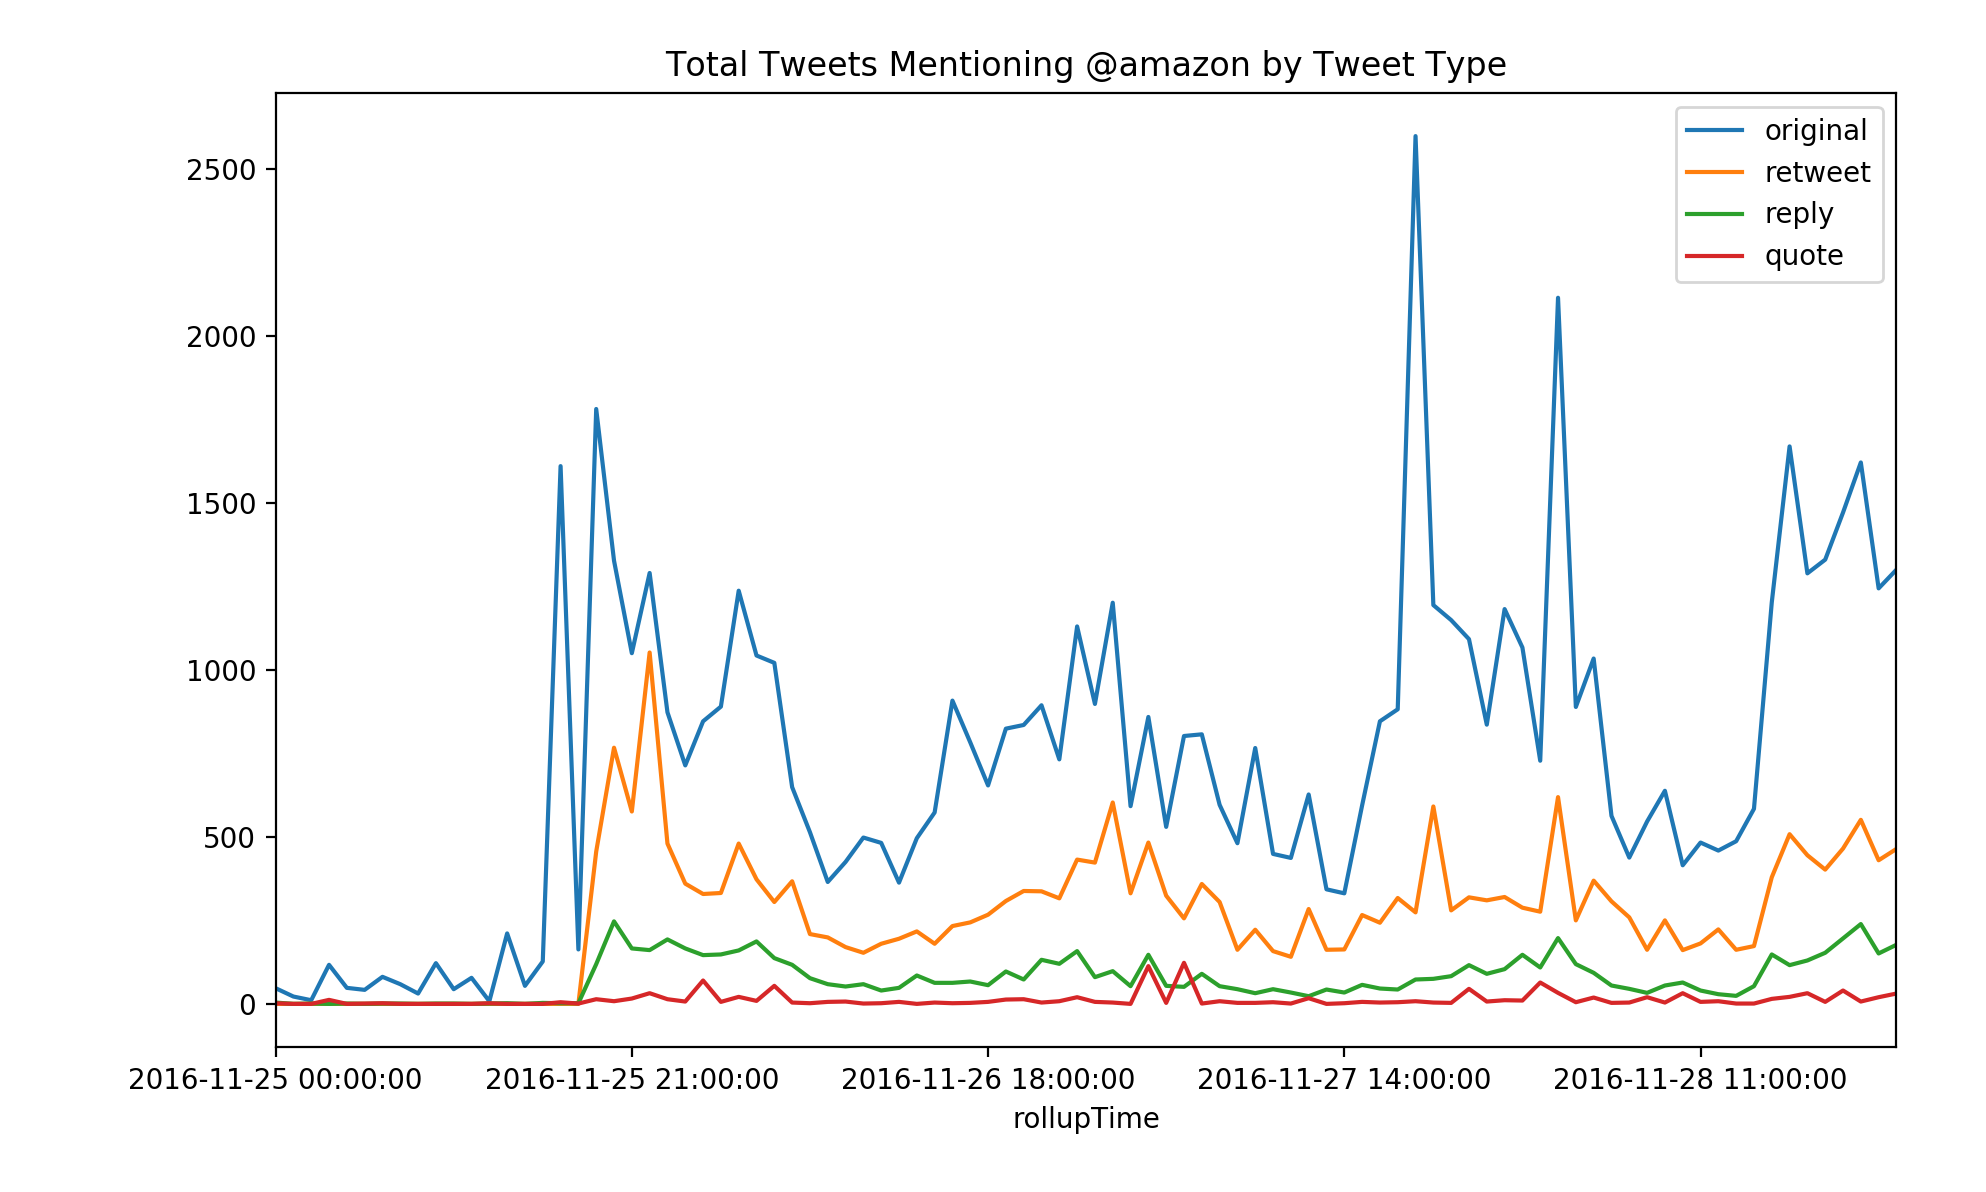

In [133]:
## Total tweets by type (retweet, quote, original) over time that mention @amazon
tweetsByType = tweets.select(from_unixtime(round((tweets.created_at/1000L+1800L)/3600L)*3600L).alias('rollupTime'),
                             'id','type')\
    .join(amazonTweets, 'id')\
    .groupBy('rollupTime')\
    .pivot('type', ['original','retweet','reply','quote'])\
    .count()\
    .na.fill(0)\
    .orderBy('rollupTime')\
    .filter('"2016-11-25" < rollupTime and rollupTime < "2016-11-29"')

tweetsByType.toPandas().plot(kind='line', x='rollupTime',
                             title='Total Tweets Mentioning @amazon by Tweet Type', legend=True)
plt.tight_layout()

<IPython.core.display.Javascript object>


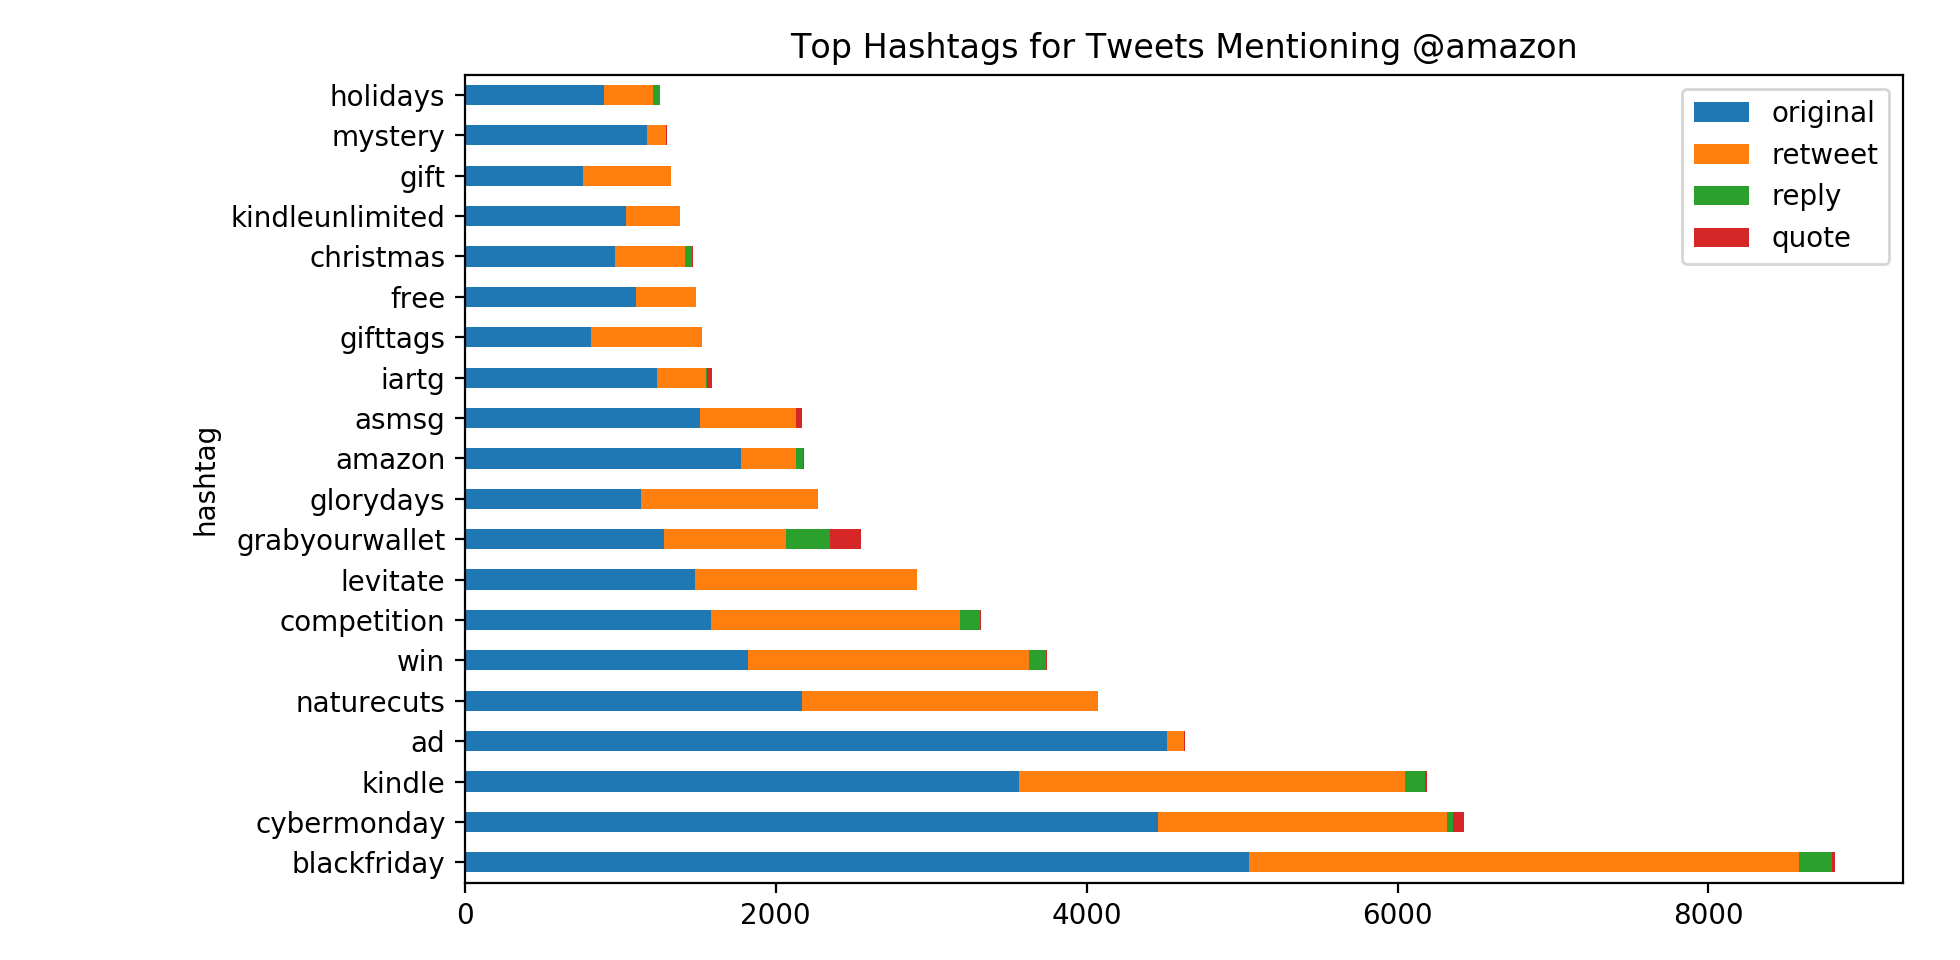

In [134]:
## Top Hashtags for tweets mentioning @amazon
hashtags = tweets.select('id','type')\
    .join(amazonTweets, 'id')\
    .join(entities, 'id')\
    .filter(entities.type == 'hashtag')\
    .withColumnRenamed('value','hashtag')\
    .groupBy('hashtag')\
    .pivot('tweets.type', ['original','retweet','reply','quote'])\
    .count()\
    .na.fill(0)\
    .orderBy(col('original')+col('retweet')+col('reply')+col('quote'), ascending=False)
    
hashtags.limit(20).toPandas().plot(kind='barh', stacked=True, x='hashtag',
                                   title='Top Hashtags for Tweets Mentioning @amazon', legend=True)
plt.tight_layout()

<IPython.core.display.Javascript object>


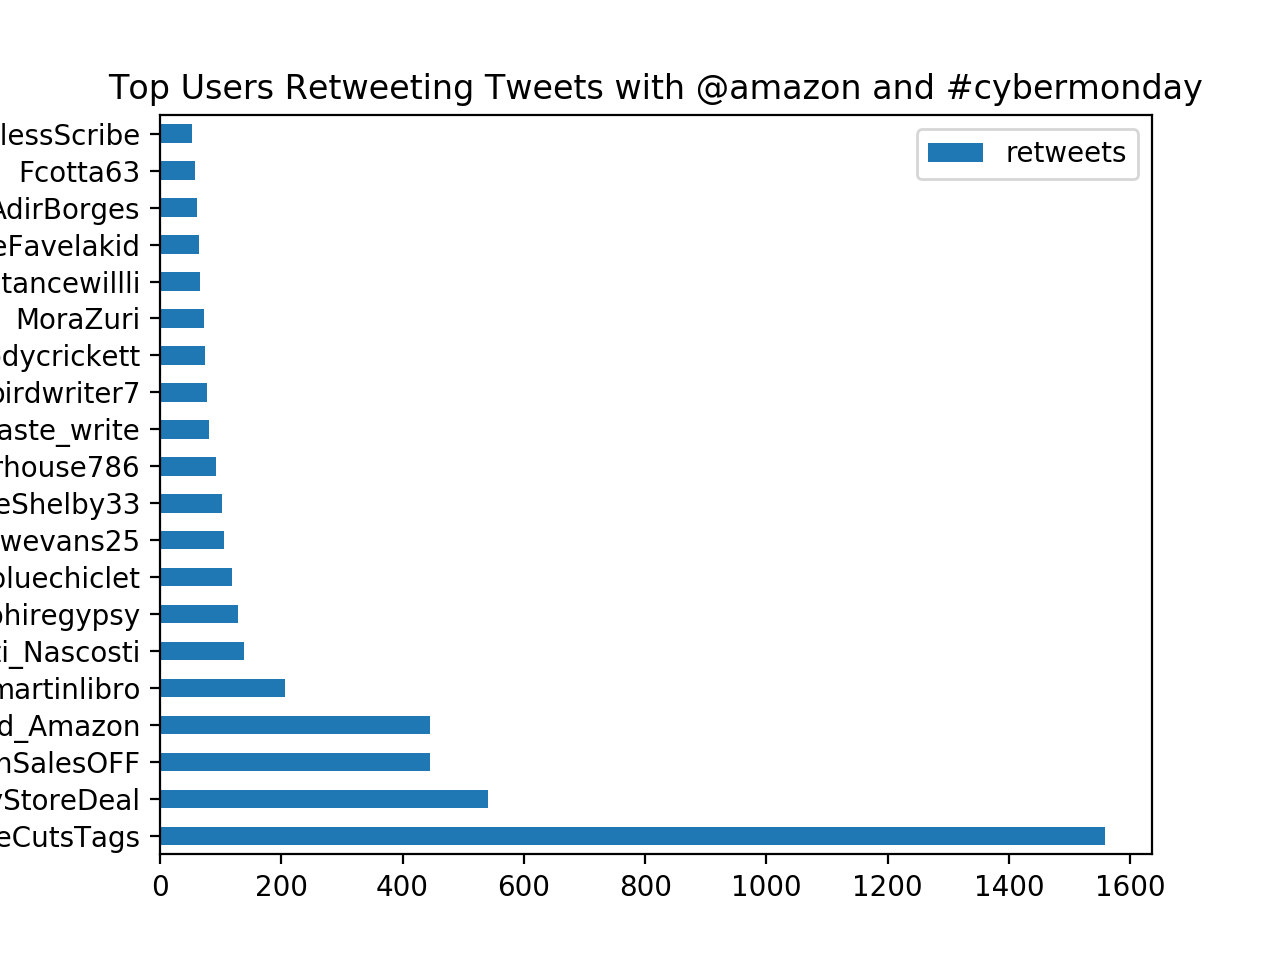

<IPython.core.display.Javascript object>


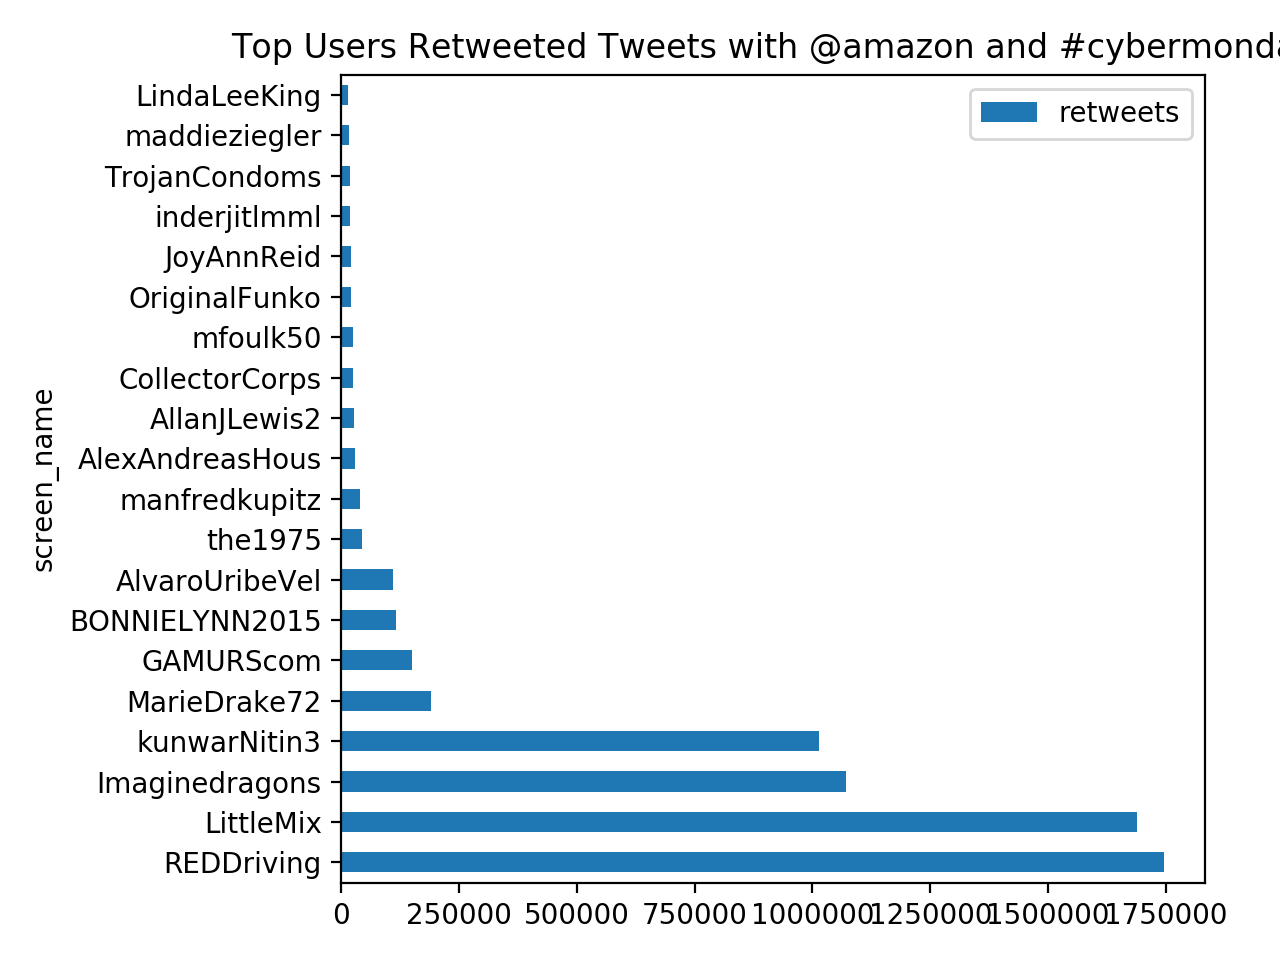

In [149]:
## Tweets mentioning @amazon and use #cybermonday
amazonCyberTweets = amazonTweets.join(entities,'id')\
    .filter('type == "hashtag" and value == "cybermonday"')\
    .select('id')\
    .distinct()

## Users retweeting 
usersRetweeting = tweets.filter('type == "retweet"')\
    .join(amazonTweets, 'id')\
    .select('user_id','id')\
    .distinct()\
    .groupBy('user_id')\
    .count()\
    .withColumnRenamed('count','retweets')\
    .join(users, tweets.user_id == users.id)\
    .select('screen_name', 'retweets')\
    .distinct()\
    .orderBy('retweets', ascending=False)

usersRetweeted = tweets.filter('type == "original"')\
    .join(amazonTweets, 'id')\
    .select('user_id', 'retweet_count')\
    .distinct()\
    .groupBy('user_id')\
    .sum('retweet_count')\
    .withColumnRenamed('sum(retweet_count)', 'retweets')\
    .join(users, tweets.user_id == users.id)\
    .select('screen_name', 'retweets')\
    .distinct()\
    .orderBy('retweets', ascending=False)

usersRetweeting.limit(20).toPandas().plot(kind='barh', x='screen_name', y='retweets',
                                          title='Top Users Retweeting Tweets with @amazon and #cybermonday')

usersRetweeted.limit(20).toPandas().plot(kind='barh', x='screen_name', y='retweets',
                                         title='Top Users Retweeted Tweets with @amazon and #cybermonday')
plt.tight_layout()